## Political blogs dataset [35 points]

We will study a political blogs dataset first compiled for the paper Lada A. Adamic and Natalie Glance, "The political blogosphere and the 2004 US Election", in Proceedings of the WWW-2005 Workshop on the Weblogging Ecosystem (2005). The dataset **nodes.txt** contains a graph with $n = 1490$ vertices ("nodes") corresponding to political blogs. Each vertex has a 0-1 label (in the 3rd column) corresponding to the political orientation of that blog. We will consider this as the true label and try to reconstruct the true label from the graph using the spectral clustering on the graph. The dataset **edges.txt** contains edges between the vertices. You may remove isolated nodes (nodes that are not connected any other nodes). 

1. (5 points)  Assume the number of clusters in the graph is $k$. Explain the meaning of $k$ here intuitively. 
2. (10 points) Use spectral clustering to find the $k = 2$, $k = 3$, and $k = 4$ clusters in the network of political blogs (each node is a blog, and their edges are defined in the file **edges.txt**. **We will treat the network as an undirectly graph; thus, when constructing the adjacency matrix, make sure to it is symmetrical.** Then report the majority labels in each cluster, when $k = 2, 3, 4$, respectively. For example, if there are $k = 2$ clusters, and their labels are $\{0, 1, 1, 1\}$ and $\{0, 0, 1\}$ then the majority label for the first cluster is 1 and for the second cluster is 0. **It is required you implementing the algorithms yourself rather than calling from a package.**

3. (5 points) Now compare the majority label with the individual labels in each cluster, and report the **mismatch rate** for each cluster, when $k = 2, 3, 4$. For instance, in the example above, the mismatch rate for the first cluster is 1/4 (only the first node differs from the majority) and the the second cluster is 1/3. 

4. (10 points) Now tune your $k$ and find the number of clusters to achieve a reasonably small **mismatch rate**. Please explain how you tune $k$ and what is the achieved mismatch rate.  

5. (5 points) Please explain the finding and what can you learn from this data analysis (e.g., node within same community tend to share the same political view, or now? Did you find blogs that share the same political view more tightly connected than otherwise?)

In [399]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix,spdiags
from scipy.sparse.linalg import eigsh, svds
from matplotlib.pyplot import figure, subplots
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

In [59]:
df_nodes = pd.read_csv("nodes.txt", sep="\t", header = None)
df_edge = pd.read_csv("edges.txt", sep="\t", header = None)

In [60]:
df_nodes.head()

,0,1,2,3
0,1,100monkeystyping.com,0,Blogarama
1,2,12thharmonic.com/wordpress,0,BlogCatalog
2,3,40ozblog.blogspot.com,0,"Blogarama,BlogCatalog"
3,4,4lina.tblog.com,0,Blogarama
4,5,750volts.blogspot.com,0,Blogarama


In [61]:
df_nodes.columns = ['ID','Blog','Label','Orientation']

In [62]:
df_nodes.head()

,ID,Blog,Label,Orientation
0,1,100monkeystyping.com,0,Blogarama
1,2,12thharmonic.com/wordpress,0,BlogCatalog
2,3,40ozblog.blogspot.com,0,"Blogarama,BlogCatalog"
3,4,4lina.tblog.com,0,Blogarama
4,5,750volts.blogspot.com,0,Blogarama


In [63]:
df_nodes.shape

(1490, 4)

In [64]:
df_edge.head()

,0,1
0,267,1394
1,267,483
2,267,1051
3,904,1479
4,904,919


In [65]:
df_edge.columns = ['ID_1','ID_2']
df_edge.head()

,ID_1,ID_2
0,267,1394
1,267,483
2,267,1051
3,904,1479
4,904,919


In [66]:
df_edge['connection'] = 1

In [157]:
df_edge_2 = df_edge.copy()
df_edge_2.columns = ['ID_2', 'ID_1','connection']

In [416]:
df_edge_3 = df_edge.append(df_edge_2)
df_edge_clean = df_edge_3[df_edge_3.duplicated()==False]
df_edge_clean.shape

(33433, 3)

In [329]:
df_edge_clean.head()

,ID_1,ID_2,connection
0,267,1394,1
1,267,483,1
2,267,1051,1
3,904,1479,1
4,904,919,1


In [366]:
node_arr = df_edge_clean['ID_1'].append(df_edge_clean['ID_2']).unique()

In [419]:
df_node = pd.DataFrame(node_arr, columns=['ID']).reset_index()
df_node.head()

,index,ID
0,0,267
1,1,904
2,2,903
3,3,982
4,4,1167


In [420]:
df_nodes = pd.merge(df_nodes, df_node, on='ID')
df_nodes.head()

,ID,Blog,Label,Orientation,index
0,1,100monkeystyping.com,0,Blogarama,731
1,2,12thharmonic.com/wordpress,0,BlogCatalog,142
2,5,750volts.blogspot.com,0,Blogarama,105
3,6,95theses.blogspot.com,0,Blogarama,499
4,7,abbadabbaduo.blogspot.com,0,"Blogarama,LeftyDirectory",1174


In [417]:
df_edge_clean = pd.merge(df_edge_clean, df_node, left_on='ID_1', right_on='ID')
df_edge_clean = pd.merge(df_edge_clean, df_node, left_on='ID_2', right_on='ID')
df_edge_clean.head()

,ID_1,ID_2,connection,index_x,ID_x,index_y,ID_y
0,267,1394,1,0,267,557,1394
1,1223,1394,1,7,1223,557,1394
2,963,1394,1,77,963,557,1394
3,919,1394,1,100,919,557,1394
4,1121,1394,1,104,1121,557,1394


In [374]:
# n as the largest Index of Nodes plus one
n = df_edge_clean.index_x.max()+1
n

1224

In [375]:
# Create scipy coordinate sparse matrix
A = coo_matrix((df_edge_clean['connection'], (df_edge_clean['index_x'], df_edge_clean['index_y'])),(n,n))

In [376]:
A.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [599]:
A.sum()

33433

In [379]:
D = np.diag(1/np.sqrt(np.sum(A, axis=1)).A1)
L = D @ A @ D

In [392]:
x, v, _= np.linalg.svd(L)

In [385]:
x.shape

(1224, 1224)

In [494]:
x

array([[ 1.09384381e-02,  1.32958972e-17,  2.04099455e-18, ...,
         9.21452090e-19,  1.17062773e-19,  1.60896249e-16],
       [ 2.32039312e-02, -4.25454042e-17, -1.93398151e-17, ...,
        -2.68545411e-18, -4.10635685e-18,  7.03080876e-15],
       [ 1.09384381e-02,  1.49545369e-18,  1.04472323e-19, ...,
         1.28716263e-17, -6.03795341e-18, -1.52309429e-01],
       ...,
       [ 5.46921903e-03, -3.73582025e-17, -5.00344078e-17, ...,
         6.71357156e-17, -1.48851405e-17,  1.48997974e-01],
       [ 5.46921903e-03, -4.26616545e-17, -4.23227265e-17, ...,
        -6.36637748e-17,  1.43258634e-17, -1.48997974e-01],
       [ 5.46921903e-03,  6.18873500e-18,  2.70769988e-17, ...,
         9.15274393e-18, -2.37496673e-17,  2.06479535e-02]])

In [569]:
k = 4
u = x[:, 0:k]  
u = u/np.repeat(np.sqrt(np.sum(u*u, axis=1).reshape(-1, 1)), k, axis=1)

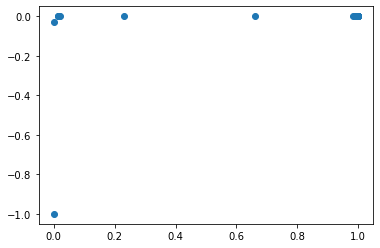

In [570]:
# scatter
plt.scatter(u[:, 0], u[:, 1])
plt.show()

In [531]:
kmeans = KMeans(n_clusters=k).fit(u)
c_idx = kmeans.labels_

In [533]:
df_label = pd.DataFrame(c_idx, columns=['Label']).reset_index()
df_label.head()

,index,Label
0,0,10
1,1,13
2,2,34
3,3,2
4,4,13


In [534]:
df_match = df_label.merge(df_nodes, on='index')
df_match.head()

,index,Label_x,ID,Blog,Label_y,Orientation
0,0,10,267,home.earthlink.net/~kevin.omeara,0,Blogarama
1,1,13,904,conservativecat.com,1,Blogarama
2,2,34,903,conservativeblogger.com,1,eTalkingHead
3,3,2,982,evilpundit.com,1,eTalkingHead
4,4,13,1167,my2cent.blogspot.com,1,Blogarama


In [535]:
df_match['Label_x'].unique()

array([10, 13, 34,  2, 35, 24, 14, 25, 42, 15,  8, 37, 31,  3, 11, 38, 16,
       21, 29, 23,  6,  7, 48, 22, 18, 32, 40,  5, 33, 39, 47, 27,  9,  4,
       17, 26,  0, 49, 41, 36, 19,  1, 28, 12, 30, 44, 45, 20, 46, 43],
      dtype=int32)

In [536]:
for i in df_match['Label_x'].unique():
    df_match.loc[df_match['Label_x']==i,'Label_cal'] = df_match.loc[df_match['Label_x']==i,'Label_y'].mode().values[0]
    df_match.loc[df_match['Label_x']==i,'mismatch'] = df_match.loc[df_match['Label_x']==i,'Label_cal'] == df_match.loc[df_match['Label_x']==i,'Label_y']

In [537]:
df_match

,index,Label_x,ID,Blog,Label_y,Orientation,Label_cal,mismatch
0,0,10,267,home.earthlink.net/~kevin.omeara,0,Blogarama,0.0,True
1,1,13,904,conservativecat.com,1,Blogarama,1.0,True
2,2,34,903,conservativeblogger.com,1,eTalkingHead,1.0,True
3,3,2,982,evilpundit.com,1,eTalkingHead,1.0,True
4,4,13,1167,my2cent.blogspot.com,1,Blogarama,1.0,True
...,...,...,...,...,...,...,...,...
1219,1219,30,471,notbush.com,0,CampaignLine,0.0,True
1220,1220,48,1046,imprescindibile.ilcannocchiale.it,1,BlogCatalog,0.0,False
1221,1221,35,44,anywhichway.net,0,Blogarama,0.0,True
1222,1222,35,59,b-patton.blogspot.com,0,Blogarama,0.0,True


In [540]:
df_match['mismatch'].count()

1224

In [575]:
rate_ls = []
for p in range(2, 100):
    k = p
    u = x[:, 0:k]  
    u = u/np.repeat(np.sqrt(np.sum(u*u, axis=1).reshape(-1, 1)), k, axis=1)
    kmeans = KMeans(n_clusters=k).fit(u)
    c_idx = kmeans.labels_
    df_label = pd.DataFrame(c_idx, columns=['Label']).reset_index()
    df_match = df_label.merge(df_nodes, on='index')
    for i in df_match['Label_x'].unique():
        df_match.loc[df_match['Label_x']==i,'Label_cal'] = df_match.loc[df_match['Label_x']==i,'Label_y'].mode().values[0]
        df_match.loc[df_match['Label_x']==i,'mismatch'] = df_match.loc[df_match['Label_x']==i,'Label_cal'] == df_match.loc[df_match['Label_x']==i,'Label_y']
    mis_rate = 1-df_match['mismatch'].sum()/df_match['mismatch'].count()
    rate_ls.append(mis_rate)

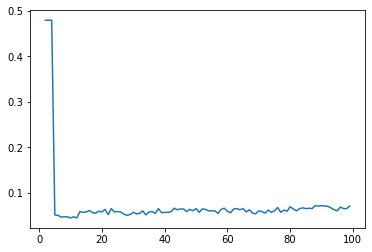

In [576]:
plt.plot(list(range(2,100)),rate_ls)

In [600]:
mis_match = {}
k = 2
u = x[:, 0:k]  
u = u/np.repeat(np.sqrt(np.sum(u*u, axis=1).reshape(-1, 1)), k, axis=1)
kmeans = KMeans(n_clusters=k).fit(u)
c_idx = kmeans.labels_
df_label = pd.DataFrame(c_idx, columns=['Label']).reset_index()
df_match = df_label.merge(df_nodes, on='index')
for i in df_match['Label_x'].unique():
    df_match.loc[df_match['Label_x']==i,'Label_cal'] = df_match.loc[df_match['Label_x']==i,'Label_y'].mode().values[0]
    df_match.loc[df_match['Label_x']==i,'mismatch'] = df_match.loc[df_match['Label_x']==i,'Label_cal'] == df_match.loc[df_match['Label_x']==i,'Label_y']
    mis_rate_i = df_match.loc[df_match['Label_x']==i,'mismatch'].sum()/df_match.loc[df_match['Label_x']==i,'mismatch'].count()   
    mis_match[i] = {}
    mis_match[i]['mis_rate'] = 1-mis_rate_i
    mis_match[i]['size'] = df_match.loc[df_match['Label_x']==i,'mismatch'].count()  
mis_rate = 1-df_match['mismatch'].sum()/df_match['mismatch'].count()
mis_match

{0: {'mis_rate': 0.4795417348608838, 'size': 1222},
 1: {'mis_rate': 0.0, 'size': 2}}

In [601]:
mis_match = {}
k = 3
u = x[:, 0:k]  
u = u/np.repeat(np.sqrt(np.sum(u*u, axis=1).reshape(-1, 1)), k, axis=1)
kmeans = KMeans(n_clusters=k).fit(u)
c_idx = kmeans.labels_
df_label = pd.DataFrame(c_idx, columns=['Label']).reset_index()
df_match = df_label.merge(df_nodes, on='index')
for i in df_match['Label_x'].unique():
    df_match.loc[df_match['Label_x']==i,'Label_cal'] = df_match.loc[df_match['Label_x']==i,'Label_y'].mode().values[0]
    df_match.loc[df_match['Label_x']==i,'mismatch'] = df_match.loc[df_match['Label_x']==i,'Label_cal'] == df_match.loc[df_match['Label_x']==i,'Label_y']
    mis_rate_i = df_match.loc[df_match['Label_x']==i,'mismatch'].sum()/df_match.loc[df_match['Label_x']==i,'mismatch'].count()   
    mis_match[i] = {}
    mis_match[i]['mis_rate'] = 1-mis_rate_i
    mis_match[i]['size'] = df_match.loc[df_match['Label_x']==i,'mismatch'].count()  
mis_rate = 1-df_match['mismatch'].sum()/df_match['mismatch'].count()
mis_match

{0: {'mis_rate': 0.4795417348608838, 'size': 1222},
 2: {'mis_rate': 0.0, 'size': 1},
 1: {'mis_rate': 0.0, 'size': 1}}

In [602]:
mis_match = {}
k = 4
u = x[:, 0:k]  
u = u/np.repeat(np.sqrt(np.sum(u*u, axis=1).reshape(-1, 1)), k, axis=1)
kmeans = KMeans(n_clusters=k).fit(u)
c_idx = kmeans.labels_
df_label = pd.DataFrame(c_idx, columns=['Label']).reset_index()
df_match = df_label.merge(df_nodes, on='index')
for i in df_match['Label_x'].unique():
    df_match.loc[df_match['Label_x']==i,'Label_cal'] = df_match.loc[df_match['Label_x']==i,'Label_y'].mode().values[0]
    df_match.loc[df_match['Label_x']==i,'mismatch'] = df_match.loc[df_match['Label_x']==i,'Label_cal'] == df_match.loc[df_match['Label_x']==i,'Label_y']
    mis_rate_i = df_match.loc[df_match['Label_x']==i,'mismatch'].sum()/df_match.loc[df_match['Label_x']==i,'mismatch'].count()   
    mis_match[i] = {}
    mis_match[i]['mis_rate'] = 1-mis_rate_i
    mis_match[i]['size'] = df_match.loc[df_match['Label_x']==i,'mismatch'].count()  
mis_rate = 1-df_match['mismatch'].sum()/df_match['mismatch'].count()
mis_match

{0: {'mis_rate': 0.48026315789473684, 'size': 1216},
 2: {'mis_rate': 0.0, 'size': 1},
 1: {'mis_rate': 0.33333333333333337, 'size': 6},
 3: {'mis_rate': 0.0, 'size': 1}}

In [598]:
mis_match = {}
k = 5
u = x[:, 0:k]  
u = u/np.repeat(np.sqrt(np.sum(u*u, axis=1).reshape(-1, 1)), k, axis=1)
kmeans = KMeans(n_clusters=k).fit(u)
c_idx = kmeans.labels_
df_label = pd.DataFrame(c_idx, columns=['Label']).reset_index()
df_match = df_label.merge(df_nodes, on='index')
for i in df_match['Label_x'].unique():
    df_match.loc[df_match['Label_x']==i,'Label_cal'] = df_match.loc[df_match['Label_x']==i,'Label_y'].mode().values[0]
    df_match.loc[df_match['Label_x']==i,'mismatch'] = df_match.loc[df_match['Label_x']==i,'Label_cal'] == df_match.loc[df_match['Label_x']==i,'Label_y']
    mis_rate_i = df_match.loc[df_match['Label_x']==i,'mismatch'].sum()/df_match.loc[df_match['Label_x']==i,'mismatch'].count()   
    mis_match[i] = {}
    mis_match[i]['mis_rate'] = 1-mis_rate_i
    mis_match[i]['size'] = df_match.loc[df_match['Label_x']==i,'mismatch'].count()  
mis_rate = 1-df_match['mismatch'].sum()/df_match['mismatch'].count()
mis_match

{4: {'mis_rate': 0.02409638554216864, 'size': 83},
 0: {'mis_rate': 0.025380710659898442, 'size': 591},
 1: {'mis_rate': 0.02145922746781115, 'size': 466},
 2: {'mis_rate': 0.42105263157894735, 'size': 76},
 3: {'mis_rate': 0.5, 'size': 8}}

In [577]:
rate_ls[:10]

[0.4787581699346405,
 0.4787581699346405,
 0.4787581699346405,
 0.05147058823529416,
 0.05065359477124187,
 0.04656862745098034,
 0.04738562091503273,
 0.04738562091503273,
 0.04493464052287577,
 0.04738562091503273]